In [78]:
import numpy as np
import matplotlib.pyplot as plt

In [79]:
Q = np.array(
    [[-0.0085, 0.005, 0.0025, 0.0, 0.001],
     [0.0, -0.014, 0.005, 0.004, 0.005],
     [0.0, 0.0, -0.008, 0.003, 0.005],
     [0.0, 0.0, 0.0, -0.009, 0.009],
     [0.0, 0.0, 0.0, 0.0, 0.00]]
)

In [80]:
def get_P_and_q(Q):
    assert np.allclose(Q.sum(axis=1), 0), "Rows of Q0 should sum to zero"

    P = np.zeros_like(Q)
    for i in range(Q.shape[0]):
        if Q[i, i] != 0:
            P[i] = Q[i] / -Q[i, i]
            P[i, i] = 0  # Set diagonal to zero

    assert np.allclose(P[:-1].sum(axis=1), 1), "Rows of P should sum to one"

    q = -1 / np.diag(Q)[:-1]

    return P, q

In [81]:
def simulate_breast_cancer(n_patients: int, Q: np.ndarray):

    P, q = get_P_and_q(Q)

    transitions = [[(0.0, 0)] for _ in range(n_patients)]  # Initialize transitions for each
    for woman in range(n_patients):
        state = 0
        t = 0.0
        while state < 4:
            t += np.random.exponential(q[state])
            state = np.random.choice(5, p=P[state])
            
            transitions[woman].append((t, state))
    
    return transitions

In [82]:
np.random.seed(42)  # For reproducibility
results = simulate_breast_cancer(1000, Q)

In [83]:
results[-10:]

[[(0.0, 0),
  (51.10228510508271, 1),
  (65.19855759523612, 3),
  (393.2301055856606, 4)],
 [(0.0, 0),
  (169.63224300574444, 1),
  (453.7012241330317, 3),
  (619.556536972616, 4)],
 [(0.0, 0), (116.2319653484796, 1), (127.50687236679214, 4)],
 [(0.0, 0), (293.7345609066661, 4)],
 [(0.0, 0),
  (115.52773984143941, 2),
  (124.46969945899315, 3),
  (166.29691969525655, 4)],
 [(0.0, 0), (51.76364539792678, 1), (116.58487376313448, 4)],
 [(0.0, 0),
  (56.643137731320394, 1),
  (72.28687652838724, 2),
  (116.85295889298934, 4)],
 [(0.0, 0), (108.07732249341798, 2), (164.35283686154423, 4)],
 [(0.0, 0),
  (26.854850150857295, 1),
  (142.15074798702489, 2),
  (156.6982508991571, 4)],
 [(0.0, 0), (49.40755388501952, 2), (52.61698072911673, 4)]]

In [84]:
def index_into_transition_list(transitions, t):
    # if we only have one transition, it is (0.0, 0)
    if len(transitions) == 1:
        return 0
    
    for (t1, s1), (t2, s2) in zip(transitions[:-1], transitions[1:]):
        if t1 <= t < t2:
            return s1
    return s2 # very fyfyskammeskamme

def transitions_to_time_series(transitions):
    t = 0
    ts = [index_into_transition_list(transitions, t)]
    while ts[-1] != 4 and t < transitions[-1][0]:
        t += 48
        ts.append(index_into_transition_list(transitions, t))
    return ts

time_series = []
for transitions in results:
    ts = transitions_to_time_series(transitions)    
    time_series.append(ts)

time_series[-10:]

[[0, 0, 3, 3, 3, 3, 3, 3, 3, 4],
 [0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 3, 3, 3, 4],
 [0, 0, 0, 4],
 [0, 0, 0, 0, 0, 0, 0, 4],
 [0, 0, 0, 3, 4],
 [0, 0, 1, 4],
 [0, 0, 2, 4],
 [0, 0, 0, 2, 4],
 [0, 1, 1, 2, 4],
 [0, 0, 4]]

In [85]:
from itertools import takewhile

def simulate_one_step(t, state, P, q):
    return t + np.random.exponential(q[state]), np.random.choice(5, p=P[state])


def find_next_time_step(ts, simulated_ts):
    i = len(simulated_ts) - 1
    current_state = simulated_ts[-1]
    while ts[i] == current_state:
        i += 1
    return (i - 1) * 48


def simulate_consistent_trajectories(time_series, Q):
    P, q = get_P_and_q(Q)

    consistent_transitions = []
    i = 0
    for ts in time_series:
        i += 1
        transitions = [(0.0, 0)]
        simulated_ts = [0]
        while not ts == simulated_ts:

            simulated_ts = transitions_to_time_series(transitions)

            # exploit memoryless property of exponential distribution
            # to avoid getting stuck on improbable trajectories
            next_t = find_next_time_step(ts, simulated_ts)

            n_transitions_added = 1
            prev_t, prev_state = transitions[-1]

            new_t, new_state = simulate_one_step(next_t, prev_state, P, q)
            transitions.append((new_t, new_state))

            while new_t < next_t + 48 and new_state != 4:
                new_t, new_state = simulate_one_step(new_t, new_state, P, q)
                transitions.append((new_t, new_state))
                n_transitions_added += 1

            simulated_ts = transitions_to_time_series(transitions)

            is_consistent = all(true == sim for (true, sim) in zip(ts, simulated_ts))

            if not is_consistent:
                transitions = transitions[:-n_transitions_added]

        consistent_transitions.append(transitions)
    return consistent_transitions

# test somewhat difficult case
simulate_consistent_trajectories([[0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 4]], Q)


[[(0.0, 0),
  (400.42711166693596, 2),
  (427.88066965930204, 3),
  (448.16287793377063, 4)]]

In [86]:
def estimate_Q(Q0, time_series):
    Q = Q0.copy()
    prev_Q = Q0.copy()
    k = 0
    while True:
        print("k =", k)
        k += 1
        trajectories = simulate_consistent_trajectories(time_series, Q)
        
        # sojourn times
        S = np.zeros(4)
        # state transition counts
        N = np.zeros((4, 5))
        
        for trajectory in trajectories:
            for (t1, s1), (t2, s2) in zip(trajectory[:-1], trajectory[1:]):
                N[s1, s2] += 1
                S[s1] += t2 - t1

        # calculate non-diagonal elements from eq. 2
        Q = N / S.reshape(-1, 1)
        # calculate diagonals from eq. 1
        np.fill_diagonal(Q, -np.sum(Q, axis=1))
        # add bottom row (death state was not included in sojourn times)
        Q = np.vstack([Q, np.zeros((1, 5))])
        
        # inifinity norm == largest absolute error
        max_diff = np.max(np.abs(Q - prev_Q))
        print("Maximum absolute error:", max_diff)

        if max_diff < 1e-3:
            break

        prev_Q = Q.copy()

    return Q       

In [88]:
Q0 = np.array(
    [[-0.012, 0.003, 0.003, 0.003, 0.003],
     [0.0, -0.012, 0.004, 0.004, 0.004],
     [0.0, 0.0, -0.012, 0.006, 0.006],
     [0.0, 0.0, 0.0, -0.012, 0.012],
     [0.0, 0.0, 0.0, 0.0, 0.00]]
)

Q_est = estimate_Q(Q0, time_series)

k = 0
Maximum absolute error: 0.00474000055761039
k = 1
Maximum absolute error: 0.0008473242449482752


RuntimeError: No mappable was found to use for colorbar creation. First define a mappable such as an image (with imshow) or a contour set (with contourf).

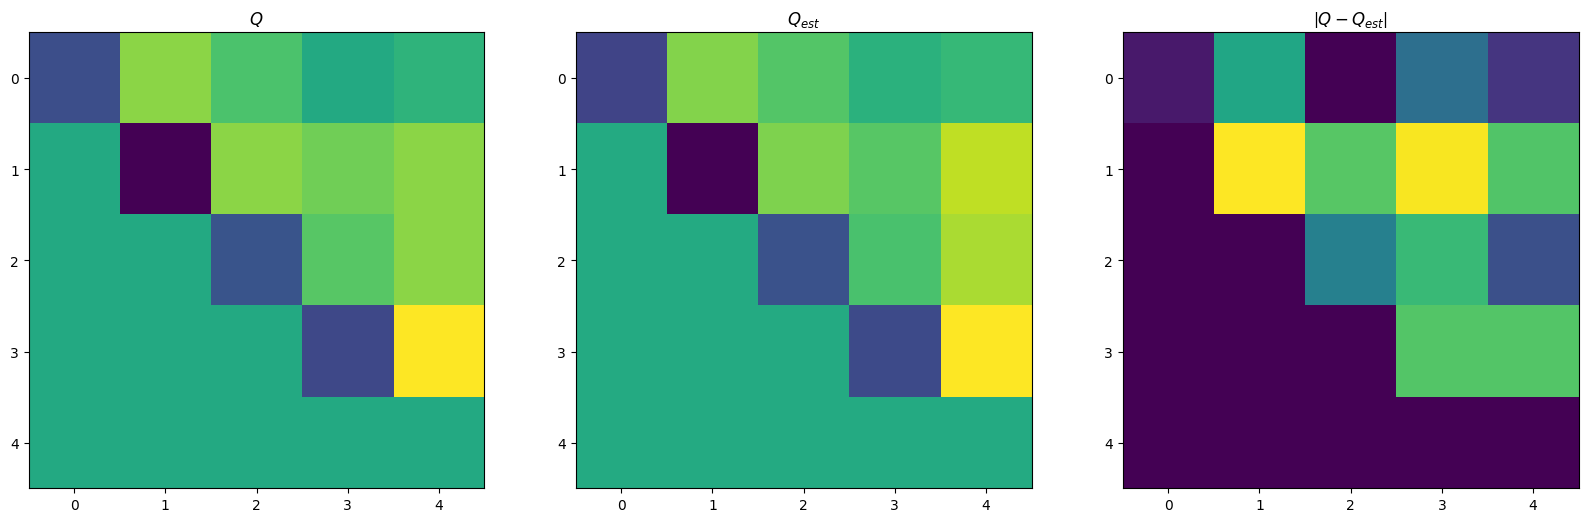

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))

ax1.set_title("$Q$")
ax1.imshow(Q)

ax2.set_title("$Q_{est}$")
ax2.imshow(Q_est)

ax3.set_title(r"$\left| Q - Q_{est} \right|$")
ax3.imshow(np.abs(Q - Q_est))